## Adam——从零开始


Adam是一个组合了动量法和RMSProp的优化算法 [1]。下面我们来介绍Adam算法。

### Adam算法
Adam算法使用了动量变量$\boldsymbol{v}$和RMSProp中小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{s}$，并将它们中每个元素初始化为0。在每次迭代中，首先计算小批量随机梯度$\boldsymbol{g}$，并递增迭代次数

$t \leftarrow t + 1.$

和动量法类似，给定超参数$\beta_1$且满足$0 \leq \beta_1 < 1$（算法作者建议设为0.9），将小批量随机梯度$\boldsymbol{g}$的指数加权移动平均记作动量变量$\boldsymbol{v}$:

$\boldsymbol{v} \leftarrow \beta_1 \boldsymbol{v} + (1 - \beta_1) \boldsymbol{g}.$

和RMSProp中一样，给定超参数$\beta_2$且满足$0 \leq \beta_2 < 1$（算法作者建议设为0.999）， 将$\boldsymbol{g}$按元素平方后做指数加权移动平均得到$\boldsymbol{s}$：

$\boldsymbol{s} \leftarrow \beta_2 \boldsymbol{s} + (1 - \beta_2) \boldsymbol{g} \odot \boldsymbol{g}$.

我们在“动量法——从零开始”一节中解释了，$\boldsymbol{v}$和$\boldsymbol{s}$可分别看作是最近$1/(1 - \beta_1)$个时刻$\boldsymbol{g}$和最近$1/(1 - \beta_2)$个时刻的$\boldsymbol{g} \odot \boldsymbol{g}$的加权平均。假设$\beta_1=0.9$，$\beta_2=0.999$，如果$\boldsymbol{v}$和$\boldsymbol{s}$中的元素都初始化为0，在时刻1我们得到$\boldsymbol{v}=0.1\boldsymbol{g}$，$\boldsymbol{s}=0.001\boldsymbol{g} \odot \boldsymbol{g}$。实际上，在迭代初期t较小时，$\boldsymbol{v}$和$\boldsymbol{s}$可能过小而无法较准确地估计$\boldsymbol{g}$和$\boldsymbol{g} \odot \boldsymbol{g}$。为此，Adam算法使用了偏差修正：

$\hat{\boldsymbol{v}} \leftarrow \frac{\boldsymbol{v}}{1 - \beta_1^t},$

$\hat{\boldsymbol{s}} \leftarrow \frac{\boldsymbol{s}}{1 - \beta_2^t}.$

由于$0 \leq \beta_1, \beta_2 < 1$，在迭代初期t较小时，上面两式的分母较接近0，相当于放大了$\boldsymbol{v}$和$\boldsymbol{s}$的值。 当迭代后期t较大时，上面两式的分母较接近1，偏差修正就几乎不再有影响。

接下来，Adam算法使用以上偏差修正后的动量变量$\hat{\boldsymbol{v}}$和RMSProp中小批量随机梯度按元素平方的指数加权移动平均变量$\hat{\boldsymbol{s}}$ ，将模型参数中每个元素的学习率通过按元素运算重新调整：

$\boldsymbol{g}^\prime \leftarrow \frac{\eta \hat{\boldsymbol{v}}}{\sqrt{\hat{\boldsymbol{s}} + \epsilon}}$,

其中$\eta$是初始学习率且$\eta>0$，$\epsilon$是为了维持数值稳定性而添加的常数，例如10−8。和Adagrad、RMSProp以及Adadelta一样，目标函数自变量中每个元素都分别拥有自己的学习率。

最后，自变量迭代步骤与小批量随机梯度下降类似：

$\boldsymbol{x} \leftarrow \boldsymbol{x} - \boldsymbol{g}^\prime.$
### Adam的实现
Adam的实现很简单。我们只需要把上面的数学公式翻译成代码。



In [22]:
def adam(params, grads, vs, sqrs, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    for param, grad, v, sqr in zip(params, grads, vs, sqrs):
        g = grad
        v[:] = beta1 * v + (1 - beta1) * g
        sqr[:] = beta2 * sqr + (1 - beta2) * np.multiply(g, g)
        v_bias_corr = v / (1 - beta1 ** t)
        sqr_bias_corr = sqr / (1 - beta2 ** t)
        param[:] = param - lr * v_bias_corr / (
            np.sqrt(sqr_bias_corr) + eps_stable)
    return params, vs, sqrs



## 实验
首先，导入实验所需的包。

In [23]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import sys
import numpy as np
import random

sys.path.append('..')

实验中，我们以之前介绍过的线性回归为例。设数据集的样本数为1000，我们使用权重w为[2, -3.4]，偏差b为4.2的线性回归模型来生成数据集。该模型的平方损失函数即所需优化的目标函数，模型参数即目标函数自变量。

In [24]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = np.random.normal(scale=1, size=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += 0.01 * np.random.normal(scale=1, size=y.shape)

# 初始化模型参数。
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros((1,))
    sqrs = []
    vs = []
    params = [w, b]
    for param in params:
        sqrs.append(np.zeros(param.shape))
        vs.append(np.zeros(param.shape))
    return params, vs, sqrs

# 构造迭代器。
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = np.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X[j], y[j]

# 线性回归模型。
def net(X, w, b):
    return np.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - np.reshape(y, yhat.shape)) ** 2 / 2

def cal_grad(yhat, y, X):
    grad_w = np.expand_dims(np.array([-np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 0]), -np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 1])]), axis=1)
    #grad_w = np.array([-np.dot((yhat - np.reshape(y, yhat.shape)).T, X[:, 0])])
    grad_b = -np.sum((yhat - np.reshape(y, yhat.shape)))
    return [grad_w, grad_b]

优化函数optimize与“梯度下降和随机梯度下降——从零开始”一节中的类似。

In [27]:
import matplotlib as mpl

import matplotlib.pyplot as plt

def train(batch_size, lr, epochs, period):
    [w, b], vs, sqrs = init_params()
    print w
    print b
    total_loss = [np.mean(square_loss(net(X, w, b), y))]
    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        # 学习率自我衰减。
        for batch_i, data, label in data_iter(batch_size):
            output = net(data, w, b)
            loss = square_loss(output, label)
            grad =  cal_grad(label, output, data)
            [w, b], vs, sqrs = adam([w, b], grad, vs, sqrs, lr, batch_size, batch_i+1)
            if batch_i * batch_size % period == 0:
                total_loss.append(
                    np.mean(square_loss(net(X, w, b), y)))
        print("Batch size %d, Epoch %d, loss %.4e" %
              (batch_size, epoch, total_loss[-1]))
    print('w:', np.reshape(w, (1, -1)),
          'b:', b, '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    mpl.rcParams['figure.figsize'] = 3.5, 2.5
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

最终，优化所得的模型参数值与它们的真实值较接近。


[[-0.91305612]
 [-0.68666153]]
[0.]
Batch size 10, Epoch 1, loss 1.4570e-03
Batch size 10, Epoch 2, loss 5.2656e-05
Batch size 10, Epoch 3, loss 5.2558e-05
('w:', array([[ 1.99924251, -3.3998811 ]]), 'b:', array([4.20047852]), '\n')


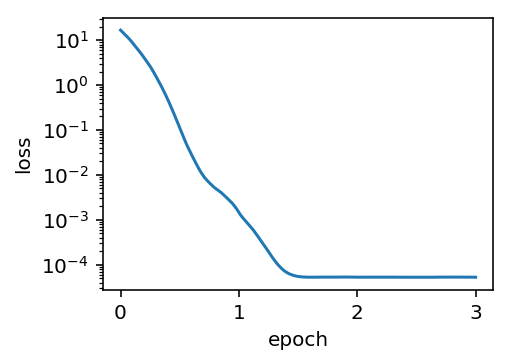

In [28]:
train(batch_size=10, lr=0.1, epochs=3, period=10)


## 小结
Adam组合了动量法和RMSProp。
Adam使用了偏差修正。